In [27]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
# Add project root to Python path
sys.path.insert(0, str(Path.cwd().parent.parent))

from src.dataPipeline import download_light_curves as dl
import lightkurve as lk

In [17]:
kep_meta = pd.read_csv("../../kepler-data/kepler_metadata.csv")

KIC10854555
SearchResult containing 6 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 07 2010 Kepler      60 kplr010854555      0.0
  1 Kepler Quarter 07 2010 Kepler      60 kplr010854555      0.0
  2 Kepler Quarter 07 2010 Kepler      60 kplr010854555      0.0
  3 Kepler Quarter 08 2011 Kepler      60 kplr010854555      0.0
  4 Kepler Quarter 08 2011 Kepler      60 kplr010854555      0.0
  5 Kepler Quarter 08 2011 Kepler      60 kplr010854555      0.0


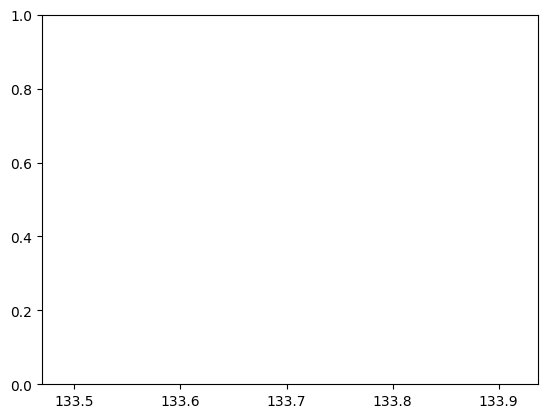

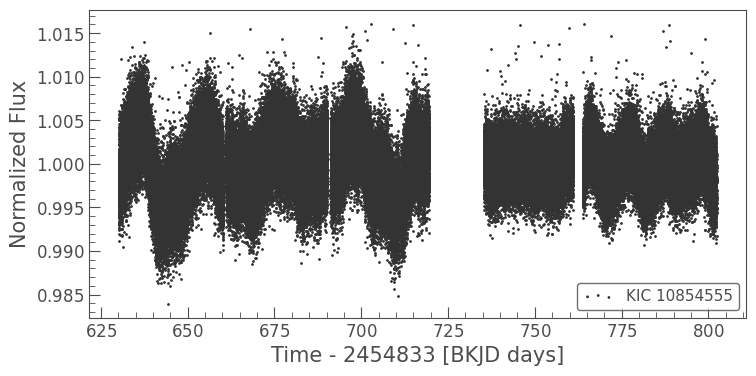

In [42]:
for ind, row in kep_meta.iterrows():
    if ind < 1:
        continue
    kep_id = f"KIC{row["kepid"]}"
    trans_epoch = row["tce_time0bk"] # is it koi_time0bk or tce_time0bk?
    trans_duration = row["tce_duration"] # also disagrees with the koi_duration
    # find out why the tce_ columns don't agree with the koi_ columns. is it just large error bars?
    print(kep_id)
    search_res = lk.search_lightcurve(kep_id, exptime=60)
    print(search_res)
    lc = search_res.download_all().stitch()
    lc = lc.remove_outliers()

    window_padding = 0.2 # days
    trans_window_min = trans_epoch - (0.5 * trans_duration / 24.0) - window_padding
    trans_window_max = trans_epoch + (0.5 * trans_duration / 24.0) + window_padding

    ax = plt.subplot()
    ax.set_xlim(trans_window_min, trans_window_max)
    # lc.scatter(ax=ax, s=5.0, fc="black")
    lc.scatter()
    plt.show()
    break